### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
#import questionary   #Tried to include this and didn't work
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
portfolio_value = 1000000 #we assume client gives us 1mm to start with.

In [4]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    print("Thank you for your response!  You are a conversative investor.")
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    print("Thank you for your response!  You are an aggressive investor.")
    tickers = ["FB","AAPL","TSLA","RDS.A","GS"]
    #Facebook, Apple, Tesla, Shell Oil, Goldman Sachs
elif int(risk_tolerance) == 3:
    print("Thank you for your response!  You are a very aggressive investor.")
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")

risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string
print(risk_tolerance)
print(tickers[0])
print(tickers)

    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  3


Thank you for your response!  You are a very aggressive investor.
3
NFLX
['NFLX', 'ADBE', 'AMZN', 'PYPL', 'GME']


In [5]:
time_horizon = input("Please select your time horizon for the forecast: 5, 10, or 20 years?")
print(time_horizon)
time_horizon = int(time_horizon) #forcing it to be an int

#type if statement here if time_horizon is not 5, 10, or 20 we prompt the user to try again

Please select your time horizon for the forecast: 5, 10, or 20 years? 20


20


In [6]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [7]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
#We can possibly make this start and end date a bit more dynamic by just pulling today's or yesterday's
#date and feeding in here as a variable.

In [8]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


ADBE                                        AMZN  \
                             open      high     low   close   volume     open   
time                                                                            
2021-10-27 00:00:00-04:00  645.37  648.8053  639.81  640.34  1348888  3389.83   

                                                               ...    NFLX  \
                           high        low     close   volume  ...    open   
time                                                           ...           
2021-10-27 00:00:00-04:00  3437  3371.4534  3393.325  2356423  ...  668.21   

                                                              PYPL            \
                             high     low   close   volume    open      high   
time                                                                           
2021-10-27 00:00:00-04:00  671.41  661.85  662.92  1892328  243.84  244.6899   

                                                     
                              low   close    volume  
time                                                 
2021-10-27 00:00:00-04:00  233.92  234.92  17689683  

[1 rows x 25 columns]

In [9]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

#fb_close_price = float(prices_df["FB"]["close"])
#aapl_close_price = float(prices_df["AAPL"]["close"])
#tsla_close_price = float(prices_df["TSLA"]["close"])
#rdsa_close_price = float(prices_df["RDS.A"]["close"])
#gs_close_price = float(prices_df["GS"]["close"])

# Print the AGG closing price
#display(fb_close_price)
#display(aapl_close_price)
#display(tsla_close_price)
#display(rdsa_close_price)
#display(gs_close_price)


662.92

640.34

3393.325

234.92

173.6

In [10]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
value_per_share = 200000 #we assume 1 million dollar investment, and 200k per share.
stock1_shares = value_per_share / stock1_close_price
stock2_shares = value_per_share / stock2_close_price
stock3_shares = value_per_share / stock3_close_price
stock4_shares = value_per_share / stock4_close_price
stock5_shares = value_per_share / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With $200,000 you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With $200,000 you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With $200,000 you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With $200,000 you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With $200,000 you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


With $200,000 you will be able to purchase 302 shares of NFLX.
With $200,000 you will be able to purchase 312 shares of ADBE.
With $200,000 you will be able to purchase 59 shares of AMZN.
With $200,000 you will be able to purchase 851 shares of PYPL.
With $200,000 you will be able to purchase 1152 shares of GME.


In [11]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
start_date = pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

limit_rows = 1000

In [12]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

ADBE                                    AMZN  \
                             open    high     low   close     volume open   
time                                                                        
2017-11-06 00:00:00-05:00  182.01  182.29  180.54  180.80  1254334.0  NaN   
2017-11-07 00:00:00-05:00  181.23  181.78  180.11  180.89  1333341.0  NaN   

                                                 ... NFLX                 \
                          high low close volume  ... open high low close   
time                                             ...                       
2017-11-06 00:00:00-05:00  NaN NaN   NaN    NaN  ...  NaN  NaN NaN   NaN   
2017-11-07 00:00:00-05:00  NaN NaN   NaN    NaN  ...  NaN  NaN NaN   NaN   

                                 PYPL                        
                          volume open high low close volume  
time                                                         
2017-11-06 00:00:00-05:00    NaN  NaN  NaN NaN   NaN    NaN  
2017-11-07 00:00:00-05:00    NaN  NaN  NaN NaN   NaN    NaN  

[2 rows x 25 columns]

ADBE                                       \
                             open      high     low   close     volume   
time                                                                     
2021-10-27 00:00:00-04:00  645.37  648.8053  639.81  640.34  1348888.0   
2021-10-28 00:00:00-04:00  638.83  642.4900  633.27  639.28  1446775.0   

                              AMZN                                          \
                              open    high        low     close     volume   
time                                                                         
2021-10-27 00:00:00-04:00  3389.83  3437.0  3371.4534  3393.325  2356423.0   
2021-10-28 00:00:00-04:00  3400.43  3479.0  3386.0000  3444.500  4040885.0   

                           ...    NFLX                                     \
                           ...    open    high     low   close     volume   
time                       ...                                              
2021-10-27 00:00:00-04:00  ...  668.21  671.41  661.85  662.92  1892328.0   
2021-10-28 00:00:00-04:00  ...  671.61  676.80  668.03  674.05  2550714.0   

                             PYPL                                        
                             open      high     low   close      volume  
time                                                                     
2021-10-27 00:00:00-04:00  243.84  244.6899  233.92  234.92  17689683.0  
2021-10-28 00:00:00-04:00  237.30  237.9400  232.78  236.82  13315878.0  

[2 rows x 25 columns]

['NFLX', 'ADBE', 'AMZN', 'PYPL', 'GME']

###Here we run a Monte Carlo simulation of 1000 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [13]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
#This part will only change based on if client selects 5 10 or 20 years to do the forecast.
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 1000,
    num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
)

# Review the simulation input data
MC_even_weight.portfolio_data.head()


ADBE                                      \
                             open     high     low   close     volume   
time                                                                    
2017-11-06 00:00:00-05:00  182.01  182.290  180.54  180.80  1254334.0   
2017-11-07 00:00:00-05:00  181.23  181.780  180.11  180.89  1333341.0   
2017-11-08 00:00:00-05:00  181.19  184.440  181.06  184.03  1235907.0   
2017-11-09 00:00:00-05:00  182.88  183.079  179.03  181.91  2120758.0   
2017-11-10 00:00:00-05:00  181.00  182.060  179.83  181.73  1333612.0   

                                           AMZN                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-06 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-07 00:00:00-05:00     0.000498      NaN      NaN      NaN      NaN   
2017-11-08 00:00:00-05:00     0.017359  1122.23  1135.54  1119.11  1132.86   
2017-11-09 00:00:00-05:00    -0.011520  1127.41  1129.62  1115.77  1129.00   
2017-11-10 00:00:00-05:00    -0.000990  1125.50  1131.75  1124.06  1125.34   

                           ...    NFLX                                   PYPL  \
                           ...     low   close     volume daily_return   open   
time                       ...                                                  
2017-11-06 00:00:00-05:00  ...     NaN     NaN        NaN          NaN    NaN   
2017-11-07 00:00:00-05:00  ...     NaN     NaN        NaN          NaN    NaN   
2017-11-08 00:00:00-05:00  ...  194.74  196.42  3266228.0          NaN  74.00   
2017-11-09 00:00:00-05:00  ...  190.81  193.89  4052164.0    -0.012881  74.02   
2017-11-10 00:00:00-05:00  ...  189.50  191.93  5262989.0    -0.010109  73.77   

                                                                         
                            high    low   close     volume daily_return  
time                                                                     
2017-11-06 00:00:00-05:00    NaN    NaN     NaN        NaN          NaN  
2017-11-07 00:00:00-05:00    NaN    NaN     NaN        NaN          NaN  
2017-11-08 00:00:00-05:00  75.00  73.31  74.775  4969617.0          NaN  
2017-11-09 00:00:00-05:00  74.20  72.41  74.100  7248108.0    -0.009027  
2017-11-10 00:00:00-05:00  74.14  73.56  73.980  4225373.0    -0.001619  

[5 rows x 30 columns]

In [14]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
MC_even_weight.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996649,1.001196,1.031378,1.015303,0.990748,0.990842,1.012814e+00,0.959234,0.980698,1.000541,...,1.008571,0.979113,1.018332,1.017707,0.971232,0.990765,1.000121,0.989943,1.008446,1.000369
2,0.989985,0.993025,1.034615,1.002218,1.041887,0.987113,1.035097e+00,0.961084,0.982960,1.009168,...,0.987242,0.955986,0.991254,0.992814,1.002203,1.001292,1.012138,1.002661,1.028602,1.024559
3,0.968859,1.008732,1.042781,1.011729,1.023799,0.999067,1.036841e+00,0.952808,1.015222,0.994572,...,0.967547,0.944352,0.980315,0.981267,0.991158,0.957780,1.017157,0.988419,1.024407,0.999766
4,0.967309,1.046403,1.040583,1.018498,1.017993,0.970718,1.065673e+00,0.975961,1.007818,1.001536,...,0.954217,0.920013,0.955543,1.002413,0.998008,1.002708,0.991840,0.997916,0.981166,0.992324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,43864.128288,29793.463960,179780.805645,2905.503988,72910.999508,104244.989889,2.970709e+06,227780.192099,8577.318288,52213.731271,...,328260.186728,679596.333095,57078.187899,456079.403335,11747.128946,34156.434504,18386.634017,12768.372898,40065.130539,315341.072077
5037,45041.983837,30753.308947,177315.176960,2869.217892,72612.669935,105560.460459,2.971062e+06,232534.323132,8444.051214,51688.040788,...,332280.603442,678006.889512,55990.642942,461226.807249,11208.212457,34270.903492,18401.059335,13082.211781,39605.419176,306964.798783
5038,43784.369526,31711.981352,177566.819903,2911.112995,70697.208096,110737.465042,2.992479e+06,225171.250075,8432.196988,51336.941560,...,326021.148060,665499.704541,57196.089827,462544.117951,11065.575120,34508.248658,18386.353356,12926.698819,38943.176453,312001.516775
5039,44012.849630,32493.364301,178690.288438,2871.279080,74182.801810,111398.179673,3.011050e+06,227323.030809,8501.946287,51604.329031,...,325771.192424,656360.721726,55152.794113,462278.067009,11108.359837,33853.045946,18760.830376,13213.991024,38670.281825,313471.851174


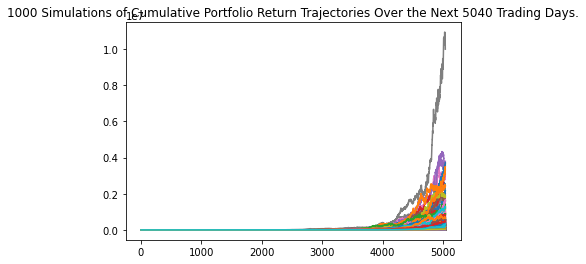

In [15]:
# Visualize the Monte Carlo simulation by creating an overlay line plot
MC_even_weight_line_plot = MC_even_weight.plot_simulation()


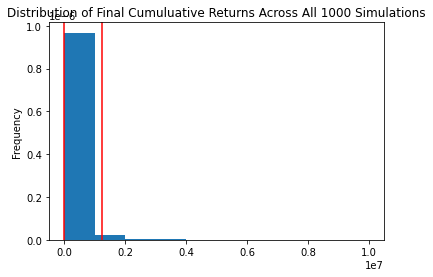

In [16]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
MC_even_weight_distibution_plot = MC_even_weight.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [17]:
# Generate summary statistics from the Monte Carlo simulation results
# We save the results as a variable
MC_even_weight_summary_table = MC_even_weight.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_summary_table)

count           1.000000e+03
mean            1.850628e+05
std             4.960330e+05
min             8.618897e+02
25%             2.061941e+04
50%             5.413690e+04
75%             1.669207e+05
max             9.993486e+06
95% CI Lower    2.992562e+03
95% CI Upper    1.234736e+06
Name: 5040, dtype: float64


In [20]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return = round(MC_even_weight_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return = round(MC_even_weight_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next {time_horizon} years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return} and ${ci_upper_thirty_cumulative_return}.")


There is a 95% chance that the current value of $1000000.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $2992561789.9 and $1234735586240.06.
